# NAIRU + Output Gap Model

## Notebook layout:

This notebook has a number of sections:
* Initial python set-up
* Primary data capture
* Building an observations table for the Bayesian modelling process
* Defining and fitting the model, checking the Bayesian/HMC diagnostics after the model has run
* Validating the model coefficients - differ from zero - theoretically sound
* Plotting the results

See the [documentation file](<Model - NAIRU+Output Gap.md>) for more information.

## Python set-up

In [1]:
# system imports
from typing import cast
import math

In [2]:
# Analytic imports
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm  # type: ignore[import-untyped]
import matplotlib.pyplot as plt
from IPython.display import display
from readabs import read_abs_series
from scipy import stats
from readabs import read_rba_ocr

In [3]:
# local imports
import mgplot as mg 
import henderson
from abs_structured_capture import ReqsDict, ReqsTuple, get_abs_data
from pymc_helper import (
    check_for_zero_coeffs,
    check_model_diagnostics, 
    get_scalar_var, 
    get_vector_var,
    plot_posteriors_bar,
    plot_posteriors_kde,
    plot_timeseries,
    posterior_predictive_checks,
    residual_autocorrelation_analysis,
)

In [4]:
# Plotting set-up
CHART_DIR = "./CHARTS/NAIRU-YGAP/"
mg.set_chart_dir(CHART_DIR)
mg.clear_chart_dir()

MODEL_NAME = r"Joint NAIRU + Output Gap -- using $\pi_e$"
RFOOTER = "ABS: 1364.0.15.003"
RFOOTER_OUTPUT = MODEL_NAME

# display charts in this notebook
SHOW = False

## Data capture

#### Utility

In [5]:
def annual_to_quarterly(annual_rate: pd.Series) -> pd.Series:
    """Convert annual inflation expectations to quarterly.
    Formula: ((1 + annual_rate/100)^(1/4) - 1) * 100"""
    return ((1 + annual_rate / 100) ** (1/4) - 1) * 100

In [6]:
def monthly_to_quarterly(data: pd.Series) -> pd.Series:
    """Convert monthly data to quarterly data by taking the mean of
    the three months in each quarter. Ignore quarters with less than
    three months data. Drop NA items."""

    return (
        data.groupby(pd.PeriodIndex(data.index, freq="Q"))
        .agg(["mean", "count"])
        .apply(lambda x: x["mean"] if x["count"] == 3 else np.nan, axis=1)
        .dropna()
    )

In [7]:
# plot the 2.5% annual inflation target in quarterly terms

QUARTERLY_RANGE = {
    "axhspan": {
        "ymin": (pow(1.02, 0.25) - 1) * 100,
        "ymax": (pow(1.03, 0.25) - 1) * 100,
        "color": "#ffdddd",
        "label": "Quarterly growth consistent with 2-3% annual inflation target",
        "zorder": -1,
    }
}

ANNUAL_RANGE = {
    "axhspan": {
        "ymin": 2,
        "ymax": 3,
        "color": "#dddddd",
        "label": "2-3% annual inflation target range",
        "zorder": -1,
    }
}

ANNUAL_TARGET = {
    "axhline": {
        "y": 2.5,
        "linestyle": "dashed",
        "linewidth": 0.75,
        "color": "darkred",
        "label": "2.5% annual inflation target",
    }
}

#### Unemployment rate

In [8]:
def get_unemployment() -> tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """Get unemployment rate, change in UE rate, and labor force growth from ABS."""

    wanted: ReqsDict = {
        "Labor Force": 
            ReqsTuple("1364.0.15.003", "1364015003", "Total labour force ;", "S", "", False, False, ""),
        "Unemployed":
            ReqsTuple("1364.0.15.003", "1364015003", "Total unemployed ;", "S", "", False, False, ""),
    }
    data = get_abs_data(wanted)
    u = (data["Unemployed"] / data["Labor Force"]) * 100
    u.name = "Unemployment Rate"

    delta_u = u.diff(1)
    delta_u.name = "Change in Unemployment Rate (ΔU)"
    delta_u_1 = delta_u.shift(1)

    # Labor force growth (4Q log difference, quarterised, COVID-adjusted)
    lf_growth_annual = np.log(data["Labor Force"]).diff(4) * 100
    lf_growth_raw = annual_to_quarterly(lf_growth_annual)
    lf_growth_henderson = henderson.hma(lf_growth_raw.dropna(), 13)
    replace = pd.period_range("2020Q1", "2023Q2", freq="Q")
    lf_growth = lf_growth_raw.where(~lf_growth_raw.index.isin(replace), other=lf_growth_henderson)

    return u, delta_u, delta_u_1, lf_growth


U, ΔU, ΔU_1, LF_growth = get_unemployment()

#### Real GDP

In [9]:
def get_real_gdp() -> tuple[pd.Series, pd.Series]:
    """Get real GDP from ABS National Accounts (5206.0).
    Returns log GDP and quarterly GDP growth."""

    # A2304402X = GDP Chain Volume Measures, Seasonally Adjusted
    nat_accounts, _meta = read_abs_series(cat="5206.0", series_id="A2304402X")
    real_gdp = nat_accounts["A2304402X"]

    # Log GDP (for output gap estimation)
    log_gdp = real_gdp.apply(np.log) * 100  # multiply by 100 for percentage scale

    # Quarterly GDP growth
    gdp_growth = log_gdp.diff(1)

    return log_gdp, gdp_growth


log_GDP, GDP_growth = get_real_gdp()

#### Labour Productivity (for time-varying potential growth)

In [10]:
def get_productivity_trend(trend_weight: float = 0.75) -> pd.Series:
    """Get labour productivity (GDP per hour worked) and calculate
    a blended measure of linear trend and raw productivity growth.

    This is used to inform time-varying potential GDP growth, based on
    the idea that productivity doesn't matter in the short run but is
    everything in the long run.

    Args:
        trend_weight: Weight on linear trend (default 0.75, remainder on raw)

    Returns:
        Blended quarterly productivity growth (trend_weight × linear + (1-trend_weight) × raw)
    """

    # GDP per hour worked from National Accounts - use data item descriptions
    wanted: ReqsDict = {
        "GDP": ReqsTuple(
            "5206.0", "5206001_Key_Aggregates",
            "Gross domestic product: Chain volume measures ;",
            "S", "", False, False, ""
        ),
        "Hours": ReqsTuple(
            "5206.0", "5206001_Key_Aggregates",
            "Hours worked: Index ;",
            "S", "", False, False, ""
        ),
    }
    data = get_abs_data(wanted)
    productivity_index = data["GDP"] / data["Hours"]

    # Calculate quarterly productivity growth (log difference * 100 for percentage)
    log_productivity = productivity_index.apply(np.log) * 100
    productivity_growth = log_productivity.diff(1).dropna()

    # Fit linear trend through productivity growth
    x = np.arange(len(productivity_growth))
    slope, intercept = np.polyfit(x, productivity_growth.values, 1)
    linear_trend = pd.Series(intercept + slope * x, index=productivity_growth.index)

    # Blend: trend_weight × linear + (1 - trend_weight) × raw
    raw_weight = 1 - trend_weight
    productivity_blend = trend_weight * linear_trend + raw_weight * productivity_growth

    return productivity_blend


productivity_trend = get_productivity_trend(trend_weight=0.75)

#### Inflation

In [11]:
def get_inflation(measure="TM") -> tuple[pd.Series, pd.Series]:
    """Get trimmed mean inflation as a measure of core inflation."""

    # -- will need a rework when the CPI is updated in late January 2026 --
    tm = "Percentage Change from Previous Period ;  Trimmed Mean ;  Australia ;"
    tm_annual = "Percentage Change from Corresponding Quarter of Previous Year ;  Trimmed Mean ;  Australia ;"
    headline = "Percentage Change from Previous Period ;  All groups CPI, seasonally adjusted ;  Australia ;"
    old_cpi = "./ABS-Data/Qrtly-CPI-Time-series-spreadsheets-all.zip"
    wanted = {
        "Trimmed Mean": ReqsTuple("", "640106", tm, "S", "", False, False, old_cpi),
        "Trimmed Mean Annual": ReqsTuple("", "640106", tm_annual, "S", "", False, False, old_cpi),
        "Headline CPI": ReqsTuple("", "640106", headline, "S", "", False, False, old_cpi),
    }
    selected = "Trimmed Mean" if measure == "TM" else "Headline CPI"
    inflation = get_abs_data(wanted)[selected]
    inflation.name = selected

    pi4 = get_abs_data(wanted)[f"{selected} Annual"]
    pi = inflation
    return pi, pi4


π, π4 = get_inflation()

In [12]:
def get_inflation_expectations() -> pd.Series:
    """Get inflation expectations: RBA series up to 2023Q1, then extended using
    fitted relationship with trimmed mean inflation.
    
    RBA PIE_RBAQ series (1970Q1-2023Q1) is heavily anchored around 2.5%.
    Extension model: π_e = 2.379 + 0.055 * TM(4Q rolling avg)
    
    Returns:
        Inflation expectations (annual rate)
    """
    
    # Load RBA series and convert to annual
    rba_pie = pd.read_csv(
        "./NAIRU_INPUTS/PIE_RBAQ.CSV",
        index_col=0,
        parse_dates=False,
    )["PIE_RBAQ"]
    rba_pie.index = pd.PeriodIndex(rba_pie.index, freq="Q")
    rba_pie = rba_pie.dropna()
    rba_annual = ((1 + rba_pie / 100) ** 4 - 1) * 100
    
    # Get trimmed mean for extension
    old_cpi = "./ABS-Data/Qrtly-CPI-Time-series-spreadsheets-all.zip"
    tm_annual = "Percentage Change from Corresponding Quarter of Previous Year ;  Trimmed Mean ;  Australia ;"
    wanted_tm = {"TM Annual": ReqsTuple("", "640106", tm_annual, "S", "", False, False, old_cpi)}
    tm = get_abs_data(wanted_tm)["TM Annual"]
    
    # Extension model fitted on 2000-2023 data
    # π_e = 2.379 + 0.055 * TM(4Q rolling avg)
    tm_roll4 = tm.rolling(4).mean()
    extended = 2.379 + 0.055 * tm_roll4
    
    # Combine: RBA up to 2023Q1, extended after
    rba_end = pd.Period("2023Q1", freq="Q")
    pi_e = rba_annual[rba_annual.index <= rba_end].copy()
    extension = extended[extended.index > rba_end]
    pi_e = pd.concat([pi_e, extension]).sort_index()
    pi_e.name = "Inflation Expectations"
    
    return pi_e


π_e = get_inflation_expectations()

#### Capital Stock (for Cobb-Douglas production function)

In [13]:
def get_capital_growth() -> pd.Series:
    """Get capital stock growth from ABS modellers database.

    Uses net capital stock of non-financial and financial corporations
    (chain volume measures) as a measure of productive business capital.

    Returns:
        Quarterly capital stock growth (log difference * 100), Henderson smoothed
    """

    wanted: ReqsDict = {
        "Capital": ReqsTuple(
            "1364.0.15.003", "1364015003",
            "Non-financial and financial corporations ; Net capital stock (Chain volume measures) ;",
            "S", "", False, False, ""
        ),
    }
    data = get_abs_data(wanted)
    capital = data["Capital"]

    # Calculate quarterly capital growth (log difference * 100 for percentage)
    log_capital = capital.apply(np.log) * 100
    capital_growth_raw = log_capital.diff(1).dropna()

    # Apply Henderson smoothing to remove noise (capital stock is slow-moving)
    capital_growth = henderson.hma(capital_growth_raw, 13)
    capital_growth.name = "Capital Growth"

    return capital_growth


capital_growth = get_capital_growth()

#### Multi-factor Productivity (for Cobb-Douglas production function)

In [14]:
def get_mfp_growth() -> pd.Series:
    """Get multi-factor productivity (MFP) growth for Cobb-Douglas production function.

    This function constructs a quarterly MFP growth series for use in the potential
    output equation. MFP measures technological progress and efficiency gains that
    aren't attributable to capital or labor inputs.

    Data source:
        ABS 5204.0 Table 13 - "Multifactor productivity - Hours worked: Percentage changes"
        Annual data, Original series, Market sector

    Processing steps:
        1. Fetch annual MFP growth from ABS 5204
        2. Apply Henderson MA (25-term) to smooth year-to-year volatility
        3. Convert annual growth to quarterly contribution (÷4)
        4. Interpolate to quarterly frequency
        5. Backfill pre-1995 periods with labour productivity trend (productivity_trend)
           where MFP data is unavailable

    Returns:
        pd.Series: Quarterly MFP growth rate (per cent per quarter), indexed by
                   period. Values represent the MFP contribution to potential
                   GDP growth each quarter.
    """

    def fill(series: pd.Series, freq: str) -> pd.Series:
        s = series.sort_index()
        full_idx = pd.period_range(s.index[0], s.index[-1], freq=freq)
        return s.reindex(full_idx).interpolate()

    wanted: ReqsDict = {
        "MFP": ReqsTuple(
            "5204.0", "5204013_Productivity",
            "Multifactor productivity - Hours worked: Percentage changes ;",
            "O", "", False, False, ""
        ),
    }
    data = get_abs_data(wanted)
    mfp_annual = data["MFP"]
    n = 25
    mfp_annual_hma = henderson.hma(mfp_annual.dropna(), n)

    # Convert annual percentage to quarterly contribution
    mfp_quarterly_rate = annual_to_quarterly(mfp_annual_hma)
    mfp_quarterly_rate = (
        mfp_quarterly_rate.to_timestamp(how="end")
        .resample("QE-DEC")
        .last()
        .to_period("Q-DEC")
    ).interpolate()
    mfp_quarterly_rate = mfp_quarterly_rate.reindex(productivity_trend.index)
    mfp_final = mfp_quarterly_rate.where(mfp_quarterly_rate.notna(), other=productivity_trend)

    return mfp_final


mfp_growth = get_mfp_growth()

#### Import prices (from ABS 6457)

In [15]:
def get_import_pricing() -> tuple[pd.Series, pd.Series]:
    """Get the import pricing data from the ABS and calculate the
    change in import prices as a proportion of the import prices."""

    # Import Price Index by Balance of Payments, index, original
    trade, _trade_meta = read_abs_series(cat="6457.0", series_id="A2298279F")
    log_import_prices = trade["A2298279F"].apply(np.log)
    delta4_log_import_prices = log_import_prices.diff(periods=4).dropna() * 100
    dlip_1 = delta4_log_import_prices.shift(periods=1).dropna()
    dlip_2 = delta4_log_import_prices.shift(periods=2).dropna()

    return dlip_1, dlip_2


Δ4ρm_1, Δ4ρm_2 = get_import_pricing()

Table 64570DO001 has no 'Index' sheet.
Table 64570DO002 has no 'Index' sheet.
Table 64570DO003 has no 'Index' sheet.


#### Unit labour costs

In [16]:
def get_ulc() -> pd.Series:
    """Quarterly unit labour costs growth."""

    nat_accounts, _nat_accounts_meta = read_abs_series(
        cat="5206.0", series_id=["A2304402X", "A2302915V"]
    )
    ulc = nat_accounts["A2302915V"] / nat_accounts["A2304402X"]
    log_ulc = ulc.apply(np.log)
    delta_ulc = (log_ulc.diff(periods=1)).dropna() * 100

    return delta_ulc


Δulc = get_ulc()

#### Global supply constraints during the COVID-19 period

In [17]:
def get_gscpi() -> tuple[pd.Series, pd.Series]:
    """Global Supply Chain Price Index. Useful for capturing global supply constraints
    associated with the COVID-19 pandemic (and subsequent reopening and the Ukraine war).
    From: https://www.newyorkfed.org/research/policy/gscpi#/interactive"""

    gscpi = pd.read_excel(
        "./NAIRU_INPUTS/gscpi_data.xls",
        sheet_name="GSCPI Monthly Data",
        index_col=0,
        parse_dates=True,
    )["GSCPI"]
    gscpi = monthly_to_quarterly(gscpi)
    gscpi.index = pd.PeriodIndex(gscpi.index, freq="Q")
    gscpi_1 = gscpi.shift(periods=1).dropna()
    gscpi_2 = gscpi.shift(periods=2).dropna()
    quarter = pd.Timestamp.today().to_period("Q")
    dummy = pd.Series(1, pd.period_range(start="1959Q1", end=quarter - 1, freq="Q"))
    mask = (dummy.index >= "2020Q1") & (dummy.index <= "2023Q2")
    dummy[mask] = 0  # key dates for the COVID period
    gscpi_1 = gscpi_1.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)
    gscpi_2 = gscpi_2.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)

    return gscpi_1, gscpi_2


ξ_1, ξ_2 = get_gscpi()

#### RBA Cash Rate

In [18]:
def get_cash_rate() -> tuple[pd.Series, pd.Series]:
    """Get extended cash rate (monthly and quarterly).
    
    Combines:
    - Historical interbank overnight rate (1976-2010) from saved file
    - Modern cash rate target (1990-present) from RBA
    
    Uses modern series where available, historical for earlier periods.
    """
    # Modern cash rate (1990 onwards)
    modern = read_rba_ocr()
    modern.index = pd.PeriodIndex(modern.index, freq="M")
    modern.name = "Cash Rate"
    
    # Historical interbank overnight rate (1976-2010) from saved file
    hist_path = "./NAIRU_INPUTS/interbank_overnight_rate_historical.parquet"
    hist_df = pd.read_parquet(hist_path)
    hist_monthly = hist_df["Interbank Overnight Cash Rate"]
    hist_monthly.index = pd.PeriodIndex(hist_monthly.index, freq="M")
    hist_monthly.name = "Cash Rate"
    
    # Combine: use historical before modern starts, modern thereafter
    hist_early = hist_monthly[hist_monthly.index < modern.index[0]]
    combined_monthly = pd.concat([hist_early, modern])
    combined_monthly = combined_monthly.sort_index()
    combined_monthly.name = "Cash Rate"
    
    # Convert to quarterly (end of quarter value)
    combined_quarterly = combined_monthly.copy()
    combined_quarterly.index = combined_quarterly.index.to_timestamp().to_period("Q")
    combined_quarterly = combined_quarterly.groupby(combined_quarterly.index).last()
    combined_quarterly.name = "Cash Rate"
    
    return combined_monthly, combined_quarterly


cash_rate_monthly, cash_rate_quarterly = get_cash_rate()

## Data wrangling

Make sure all the vectors are the same length, with no missing data, and in the correct vector format

In [19]:
def build_obs() -> tuple[dict[str, np.ndarray], pd.PeriodIndex]:
    """Here, we standardise the length of all observations
    and place them into the obs dictionary, which is returned.
    Because the PeriodIndex data has been removed from the
    "observations matrix", we also return the index separately."""

    observed = pd.DataFrame(
        {
            # Inflation
            "π": π,         # core inflation level
            "π4": π4,       # annual core inflation level
            "π_e": π_e,     # anchored inflation expectations (annual)
            # Unemployment
            "U": U,  # unemployment rate
            "ΔU": ΔU,  # change in UE rate
            "ΔU_1": ΔU_1,  # lagged change in UE rate
            "ΔU_1_over_U": ΔU_1 / U,  # UE rate change as proportion of UE rate
            # GDP and production function inputs
            "log_gdp": log_GDP,  # log real GDP (scaled by 100)
            "gdp_growth": GDP_growth,  # quarterly GDP growth
            "capital_growth": capital_growth,  # capital stock growth (Henderson smoothed)
            "lf_growth": LF_growth,  # labor force growth (pop × participation)
            "mfp_growth": mfp_growth,  # multi-factor productivity growth (ABS 5204)
            # Other
            "Δ4ρm_1": Δ4ρm_1,  # annual change in import prices
            "Δulc": Δulc,  # unit labour costs growth
            "ξ_2": ξ_2,  # lagged supply shock
            "time_trend": pd.Series(
                np.arange(len(π)), index=π.index
            ),  # linear time trend
            "cash_rate": cash_rate_quarterly,  # policy rate
        }
    )

    print(observed.tail())
    observed = observed.dropna(
        how="any"
    )  # Note ulc comes from Nat Accounts, which is delayed data
    print(
        f"Number of periods: {len(observed)}; from: "
        f"{observed.index[0]}, concluding: {observed.index[-1]}"
    )

    return {str(x): y.to_numpy() for x, y in observed.items()}, cast(
        pd.PeriodIndex, observed.index
    )


obs, obs_index = build_obs()

          π   π4       π_e         U        ΔU      ΔU_1  ΔU_1_over_U  \
2024Q4  0.6  3.3  2.583875  3.923515 -0.198420  0.138805     0.035378   
2025Q1  0.7  2.9  2.568750  4.042736  0.119221 -0.198420    -0.049081   
2025Q2  0.7  2.7  2.550875  4.076158  0.033422  0.119221     0.029248   
2025Q3  1.0  3.0  2.542625  4.237564  0.161406  0.033422     0.007887   
2025Q4  NaN  NaN       NaN       NaN       NaN       NaN          NaN   

            log_gdp  gdp_growth  capital_growth  lf_growth  mfp_growth  \
2024Q4  1342.625929    0.538222        0.569629   0.459262    0.014069   
2025Q1  1342.997307    0.371378        0.557631   0.500855    0.009229   
2025Q2  1343.728506    0.731199        0.547814   0.567605    0.004389   
2025Q3  1344.119086    0.390580        0.540487   0.406671    0.004389   
2025Q4          NaN         NaN             NaN        NaN         NaN   

          Δ4ρm_1      Δulc  ξ_2  time_trend  cash_rate  
2024Q4  1.133371  1.647770  0.0       305.0       4.35  
20

In [20]:
# Quick grid plot of all observation variables
def plot_obs_grid(obs: dict[str, np.ndarray], obs_index: pd.PeriodIndex) -> None:
    """Plot all observation variables in a grid for quick visual inspection."""
    
    n_vars = len(obs)
    n_cols = 4
    n_rows = math.ceil(n_vars / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 2.5 * n_rows))
    axes = axes.flatten()
    
    ax = None
    for i, (name, values) in enumerate(obs.items()):
        ax = axes[i]
        ax.plot(obs_index.to_timestamp(), values, lw=1)
        ax.set_title(name, fontsize=9)
        ax.axhline(0, color="grey", lw=0.5, ls="--")
        ax.tick_params(axis="both", labelsize=7)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    fig.suptitle("Model Input Variables", fontsize=11, y=1.02)
    fig.tight_layout()
    plt.savefig(f"{CHART_DIR}obs_grid", bbox_inches="tight", dpi=300)
    plt.close()


plot_obs_grid(obs, obs_index)

In [21]:
def compute_r_star(
    inputs: dict[str, np.ndarray],
    obs_index: pd.PeriodIndex,
    alpha: float = 0.3,
    smooth_term: int = 13,
) -> np.ndarray:
    """Compute r* as smoothed Cobb-Douglas potential growth.
    
    r* ≈ α·g_K + (1-α)·g_L + g_MFP (annualized and smoothed)
    
    This is computed deterministically before MCMC, using a fixed alpha.
    The smoothing removes business cycle noise, consistent with r* being
    a long-run equilibrium concept.
    
    Args:
        inputs: Model inputs dict containing capital_growth, lf_growth, mfp_growth
        obs_index: PeriodIndex for the observation period
        alpha: Capital share (default 0.3, typical national accounts value)
        smooth_term: Henderson MA term (default 13)
    
    Returns:
        r* as numpy array (annual rate, same length as inputs)
    """
    # Quarterly potential growth from Cobb-Douglas
    quarterly_growth = (
        alpha * inputs["capital_growth"]
        + (1 - alpha) * inputs["lf_growth"]
        + inputs["mfp_growth"]
    )
    
    # Convert to annual rate (4Q rolling sum)
    quarterly_series = pd.Series(quarterly_growth, index=obs_index)
    annual_growth = quarterly_series.rolling(4).sum()
    
    # Fill initial NaNs with first valid value for smoothing
    annual_growth = annual_growth.bfill()
    
    # Apply Henderson smoothing
    r_star_smoothed = henderson.hma(annual_growth, smooth_term)
    
    return r_star_smoothed.values


# Compute r* for use in IS equation
r_star = compute_r_star(obs, obs_index)
print(f"r* range: {r_star.min():.2f}% to {r_star.max():.2f}%")
print(f"r* current: {r_star[-1]:.2f}%")

r* range: 1.11% to 5.00%
r* current: 2.09%


## Bayesian model

### The PyMC Model

This model jointly estimates the NAIRU and potential output using a Cobb-Douglas production function approach.

**Key equations:**
1. **NAIRU**: Random walk $U^{*}_{t} = U^{*}_{t-1} + \epsilon_{U^*}$
2. **Potential Output**: Cobb-Douglas growth accounting $Y^*_t = Y^*_{t-1} + \alpha \cdot g^K_t + (1-\alpha) \cdot g^L_t + g^{MFP}_t + \epsilon_{Y^*}$
3. **Phillips Curve** (expectations-augmented/shocks-augmented): $\pi_t = \frac{\pi^e_t}{4} + \gamma_{\pi}\frac{(U_t - U^*_t)}{U_t} + \rho_{\pi}\Delta_4 \rho^{m}_{t-1} + \xi_{\pi}\Xi^2_{t-2} + \epsilon_{\pi}$
4. **Okun's Law**: Links unemployment changes to output gap $\Delta U_t = \beta_{okun}(Y_t - Y^{*}_t) + \epsilon_{okun}$
5. **Wage Equation**: Links wage growth to labour market slack $\Delta ulc_t = \alpha_{wg} + \gamma_{wg}\frac{(U_t - U^*_t)}{U_t} + \lambda_{wg}\frac{\Delta U_{t-1}}{U_t} + \epsilon_{wg}$
6. **Investment=Savings (IS) Curve**: Links output gap to real interest rate gap $y_{gap,t} = \rho_{IS} \cdot y_{gap,t-1} - \beta_{IS}(r_{t-2} - r^*) + \epsilon_{IS}$

See the [documentation file](<Model - NAIRU+Output Gap.md>) for detailed descriptions of each equation.

### Utility

In [22]:
def set_model_coefficients(model: pm.Model, settings: dict, constant: dict) -> dict:
    """Set model coefficients from a settings dictionary. Return those
    coefficients in a dictionary.
    Note: the coefficients are typically stochastic variables in the model,
    using the normal distribution if mu is specified, or the half-normal."""

    coefficients = {}
    with model:
        for key in settings:
            if key in constant:
                coefficients[key] = constant[key]
                print(f"Fixed constant: {key} = {constant[key]}")
                continue
            if "mu" in settings[key]:
                coefficients[key] = pm.Normal(key, **settings[key])
                continue
            coefficients[key] = pm.HalfNormal(key, **settings[key])
        
        # Add any fixed coefficients from constant that weren't in settings
        for key in constant:
            if key not in coefficients:
                coefficients[key] = constant[key]
                print(f"Extra constant: {key} = {constant[key]}")

    return coefficients


# Note: PI_TARGET_QUARTERLY no longer used - model now uses expectations-augmented Phillips curve
# PI_TARGET_QUARTERLY = (1.025 ** 0.25 - 1) * 100  # ≈ 0.617%

### NAIRU state-space equation

In [23]:
def nairu_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    constant: dict | None = None,
) -> pm.GaussianRandomWalk:
    """Gaussian random walk for the NAIRU. This is a state space equation."""

    if constant is None:
        constant = {}

    with model:
        settings = {
            "nairu_innovation": {"mu": 0.3, "sigma": 0.1},
        }
        mc = set_model_coefficients(model, settings, constant)

        nairu = (
            pm.GaussianRandomWalk(
                "nairu",
                mu=0,  # no drift in this model
                sigma=mc["nairu_innovation"],
                init_dist=pm.Normal.dist(mu=15.0, sigma=8.0),
                steps=len(inputs["U"]) - 1,
            )
            if "nairu" not in constant
            else constant["nairu"]
        )

    return nairu

### Potential output equation (a state-space equation)

In [24]:
def potential_output_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    constant: dict | None = None,
) -> pm.Deterministic:
    """Potential output with Cobb-Douglas production function.
    
    Potential growth is modelled as:
        drift_t = α × capital_growth_t + (1-α) × lf_growth_t + mfp_growth_t
    
    Where:
        - capital_growth_t is quarterly growth in net capital stock (Henderson smoothed)
        - lf_growth_t is quarterly labor force growth (population × participation)
        - mfp_growth_t is multi-factor productivity growth (from ABS 5204)
        - α is the capital share of income (~0.3)
    
    This Cobb-Douglas formulation decomposes potential GDP growth into:
        1. Capital accumulation (α × g_K)
        2. Labor force growth ((1-α) × g_L)
        3. Multi-factor productivity (g_MFP)
    
    Production function: Y = A × K^α × L^(1-α)
    In logs: ln(Y) = ln(A) + α×ln(K) + (1-α)×ln(L)
    Growth rates: g_Y = g_MFP + α×g_K + (1-α)×g_L
    
    MFP comes directly from ABS growth accounting estimates, avoiding
    circular derivation from other model inputs.
    """

    if constant is None:
        constant = {}

    with model:
        settings = {
            "alpha_capital": {"mu": 0.3, "sigma": 0.05},  # capital share (~0.3)
            "potential_innovation": {"mu": 0.1, "sigma": 0.05},
            "initial_potential": {"mu": inputs["log_gdp"][0], "sigma": inputs["log_gdp"][0] * 0.1},
        }
        mc = set_model_coefficients(model, settings, constant)

        # Capital share parameter
        alpha = mc["alpha_capital"]
        
        # Cobb-Douglas drift: α×g_K + (1-α)×g_L + g_MFP
        drift = (
            alpha * inputs["capital_growth"]
            + (1 - alpha) * inputs["lf_growth"]
            + inputs["mfp_growth"]
        )

        # Initial value close to first observed log GDP
        init_value = mc["initial_potential"]
        
        # Build potential output manually since GaussianRandomWalk doesn't support
        # time-varying drift directly. We use a cumulative sum approach.
        
        # Innovation term (random shocks to potential)
        innovations = pm.Normal(
            "potential_innovations",
            mu=0,
            sigma=mc["potential_innovation"],
            shape=len(inputs["log_gdp"]),
        )
        
        # Potential output = initial + cumulative(drift + innovations)
        potential_output = pm.Deterministic(
            "potential_output",
            init_value + pm.math.cumsum(drift + innovations)
        )

    return potential_output

### Okun's law equation

In [25]:
def okun_law_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    potential_output: pm.GaussianRandomWalk,
    constant: dict | None = None,
) -> None:
    """Okun's Law linking output gap to change in unemployment.
    
    Change form of Okun's Law:
        ΔU = β × output_gap + ε
        ΔU = β × (Y - Y*) + ε
    
    Where:
        - ΔU is the observed quarterly change in unemployment rate (pp)
        - output_gap = (log_gdp - potential_output), i.e. (Y - Y*) in log terms
        - β is negative: when Y > Y* (positive gap), unemployment falls (ΔU < 0)
    
    This change form avoids relating two I(1) series and is more robust.
    
    Interpretation of β (beta_okun):
        - Expected to be negative
        - When output is 1% above potential, unemployment changes by β pp
        - Typical values: β ≈ -0.1 to -0.3 for quarterly data
        - E.g., β = -0.2 means 1% output gap → -0.2pp change in unemployment
    """

    if constant is None:
        constant = {}

    with model:
        settings = {
            "beta_okun": {"mu": -0.2, "sigma": 0.15},  # Okun coefficient for change form
            "epsilon_okun": {"sigma": 0.5},  # error term for ΔU
        }
        mc = set_model_coefficients(model, settings, constant)

        # output gap: (Y - Y*) in log terms (already scaled by 100, so units are %)
        output_gap = inputs["log_gdp"] - potential_output
        
        # Okun's Law (change form): ΔU = β × output_gap
        # When Y > Y* (positive gap), unemployment falls (ΔU < 0 with β < 0)
        _okun = pm.Normal(
            "okun_law",
            mu=mc["beta_okun"] * output_gap,
            sigma=mc["epsilon_okun"],
            observed=inputs["ΔU"],
        )

### Price inflation equation

In [26]:
def price_inflation_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    constant: dict | None = None,
) -> None:
    """Expectations-augmented Phillips Curve.
    
    Uses anchored inflation expectations rather than deviation from fixed target.
    Model: π = π_e/4 + γ × u_gap + controls + ε
    
    The inflation expectations (π_e) are annual and converted to quarterly.
    """

    if constant is None:
        constant = {}

    with model:
        settings = {
            "rho_pi": {"mu": 0.0, "sigma": 0.1},       # import prices pass-through
            "gamma_pi": {"mu": -0.5, "sigma": 0.3},    # unemployment gap
            "xi_2sq_pi": {"mu": 0.0, "sigma": 0.1},    # COVID disruptions
            "epsilon_pi": {"sigma": 0.25},             # error term
        }
        mc = set_model_coefficients(model, settings, constant)

        # Calculate unemployment gap (relative to NAIRU)
        u_gap = (inputs["U"] - nairu) / inputs["U"]
        
        # Expected quarterly inflation from anchored annual expectations
        pi_expected_quarterly = inputs["π_e"] / 4

        # Phillips curve: π = π_e/4 + γ × u_gap + controls
        _observed_price_inflation = pm.Normal(
            "observed_price_inflation",
            mu=pi_expected_quarterly
            + mc["rho_pi"] * inputs["Δ4ρm_1"]  # import prices
            + mc["gamma_pi"] * u_gap  # unemployment gap
            + mc["xi_2sq_pi"] * inputs["ξ_2"] ** 2 * np.sign(inputs["ξ_2"]),  # COVID
            sigma=mc["epsilon_pi"],
            observed=inputs["π"],  # observe actual inflation directly
        )

### Wage Growth Equation

In [27]:
def wage_growth_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    constant: dict | None = None,
) -> None:
    """Wage growth likelihood equation - minimal specification."""

    if constant is None:
        constant = {}

    with model:
        settings = {
            "alpha_wg": {"mu": 0, "sigma": 1.0},        # intercept
            "gamma_wg": {"mu": -1.5, "sigma": 1.0},     # unemployment gap
            "lambda_wg": {"mu": -4.0, "sigma": 2.0},    # UE rate change (speed limit)
            "epsilon_wg": {"sigma": 1.0},              # error term
        }
        mc = set_model_coefficients(model, settings, constant)

        _observed_wage_growth = pm.Normal(
            "observed_wage_growth",
            mu=mc["alpha_wg"]
                  + mc["gamma_wg"] * ((inputs["U"] - nairu) / inputs["U"])
                  + mc["lambda_wg"] * inputs["ΔU_1_over_U"],
            sigma=mc["epsilon_wg"],
            observed=inputs["Δulc"],
        )

### IS Equation

In [28]:
def is_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    potential_output,
    r_star: np.ndarray,
    constant: dict | None = None,
) -> None:
    """IS curve linking output gap to real interest rate gap.
    
    IS equation: y_gap_t = ρ·y_gap_{t-1} - β·(r_{t-2} - r*) + ε
    
    Implemented as likelihood on log_gdp:
        log_gdp_t = potential_t + ρ·(log_gdp_{t-1} - potential_{t-1}) - β·(r_{t-2} - r*) + ε
    
    Args:
        inputs: Model inputs (must include log_gdp, cash_rate, π_e)
        model: PyMC model
        potential_output: Latent potential output from potential_output_equation
        r_star: Pre-computed natural rate (smoothed, annual %)
        constant: Fixed parameters (optional)
    """
    if constant is None:
        constant = {}

    with model:
        settings = {
            "rho_is": {"mu": 0.85, "sigma": 0.1},     # output gap persistence
            "beta_is": {"mu": 0.15, "sigma": 0.1},    # interest rate sensitivity
            "epsilon_is": {"sigma": 0.4},             # error term
        }
        mc = set_model_coefficients(model, settings, constant)

        # Real interest rate: i - π_e (both annual rates)
        real_rate = inputs["cash_rate"] - inputs["π_e"]
        
        # Real rate gap: (r - r*)
        rate_gap = real_rate - r_star
        
        # Lagged rate gap (lag=2): for t=2,3,...,T-1, use rate_gap at t-2
        rate_gap_lag2 = rate_gap[:-2]  # indices 0 to T-3
        
        # Output gap = log_gdp - potential_output
        output_gap = inputs["log_gdp"] - potential_output
        
        # Lagged output gap: y_gap_{t-1} for t=2,...,T-1
        output_gap_lag1 = output_gap[1:-1]
        
        # Potential at time t (for t=2,...,T-1)
        potential_t = potential_output[2:]
        
        # IS equation predicts log_gdp_t:
        # log_gdp_t = potential_t + ρ·y_gap_{t-1} - β·rate_gap_{t-2}
        predicted_log_gdp = (
            potential_t
            + mc["rho_is"] * output_gap_lag1
            - mc["beta_is"] * rate_gap_lag2
        )
        
        # Likelihood on observed log GDP (from t=2 onwards)
        _is_curve = pm.Normal(
            "is_curve",
            mu=predicted_log_gdp,
            sigma=mc["epsilon_is"],
            observed=inputs["log_gdp"][2:],
        )

### The model

In [49]:
def define_model(
    inputs: dict[str, np.ndarray],
    r_star: np.ndarray | None = None,
) -> pm.Model:
    """Define the joint NAIRU + Output Gap model.

    Args:
        inputs: Model inputs dictionary
        r_star: Pre-computed natural rate for IS equation (optional)
                If provided, IS equation is included in the model
    """

    model = pm.Model()

    # Fix innovation parameters for better convergence
    # Note: potential drift is now time-varying based on productivity trend
    nairu_const = {"nairu_innovation": 0.25}
    potential_const = {"potential_innovation": 0.3}

    # State space equations
    nairu = nairu_equation(inputs, model, constant=nairu_const)
    potential_output = potential_output_equation(inputs, model, constant=potential_const)

    # Okun's Law - links the two gaps
    okun_law_equation(inputs, model, nairu, potential_output)

    # Price inflation equation
    price_inflation_equation(inputs, model, nairu, constant={})

    # Wage equation
    wage_growth_equation(inputs, model, nairu)

    # IS equation (if r_star provided)
    if r_star is not None:
        is_equation(inputs, model, potential_output, r_star)

    return model


the_model = define_model(inputs=obs, r_star=r_star)

Fixed constant: nairu_innovation = 0.25
Fixed constant: potential_innovation = 0.3


### Fit the model to the data

In [30]:
N_CORES: int = 5
SAMPLES: int = 100_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
TUNE: int = 7_500  # per chain

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
    "target_accept": 0.90,  # increased from default 0.8 to reduce divergences
}

In [31]:
def fit_the_model(model: pm.Model, args: dict) -> az.InferenceData:
    """Fit the data to the model."""

    with model:
        idata = pm.sample(
            **args,
            progressbar=True,
            return_inferencedata=True,
        )
        az.plot_trace(idata)
    return idata

### Run the model

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

  0%|          | 0/27500 [00:00<?, ?it/s]

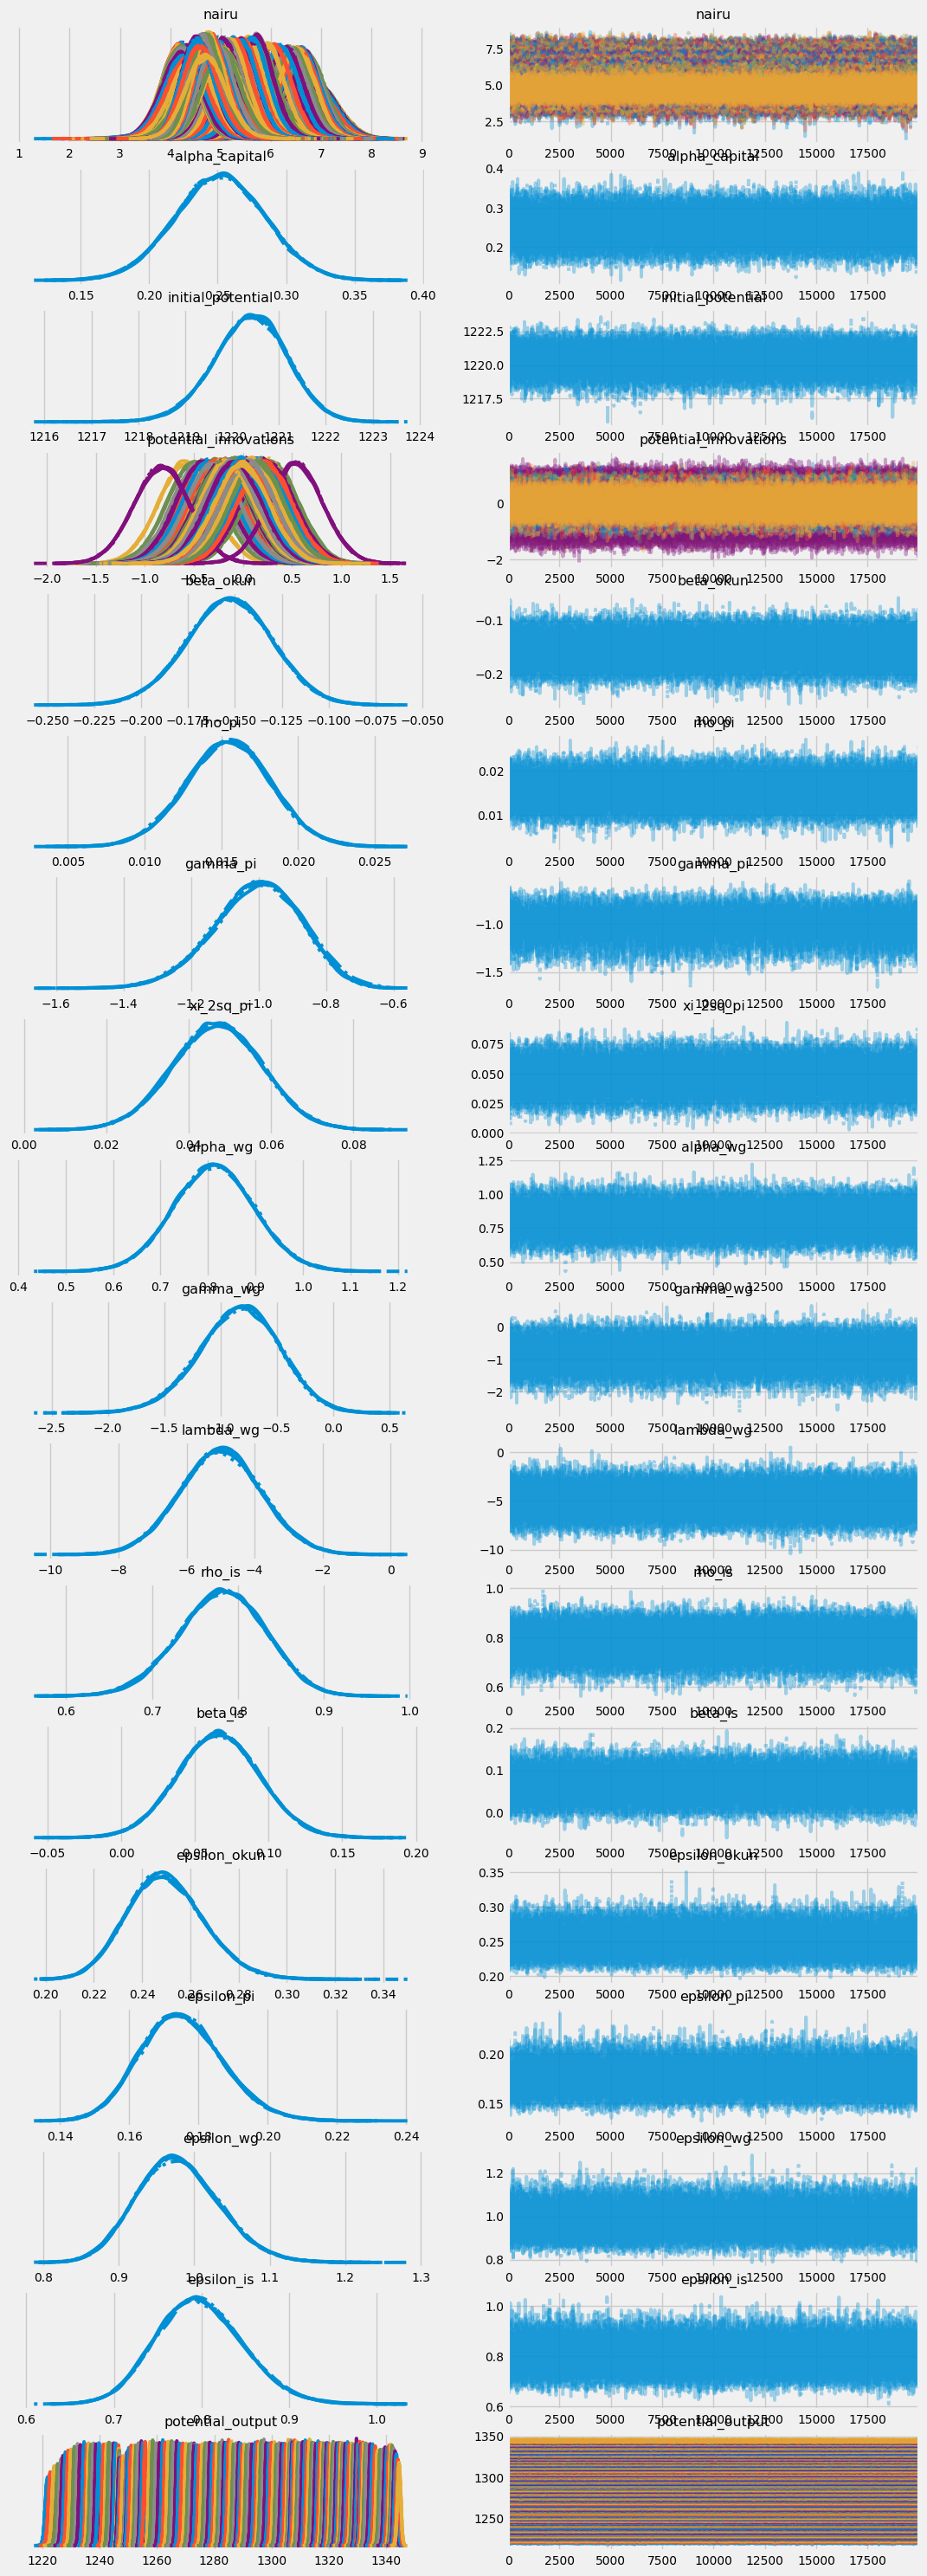

In [32]:
inference_data = fit_the_model(the_model, SAMPLE_ARGS)
# tajes abiut 1 minute to sample, and up to 1.5 minutes to package up the samples

### Check diagnostics from Bayesian model fitting

In [33]:
check_model_diagnostics(inference_data)

Maximum R-hat convergence diagnostic: 1.0
Minimum effective sample size (ESS) estimate: 4872
Maximum MCSE/sd ratio: 0.015
Divergent transitions: 0/100000 (0.0000%)
Tree depth at max (10): 0.00% (note: comparing to observed max, not configured)
Minimum Bayesian fraction of missing information: 0.93


## Model coefficient validation

* check all scalar coefficients differ from zero
* check values correspond with theoretical expectations

### Coefficients differ from zero

In [34]:
check_for_zero_coeffs(
    inference_data, 
    critical_params=["gamma_pi", "gamma_wg", "beta_okun"]
).T

,alpha_capital,alpha_wg,beta_is,beta_okun,epsilon_is,epsilon_okun,epsilon_pi,epsilon_wg,gamma_pi,gamma_wg,initial_potential,lambda_wg,rho_is,rho_pi,xi_2sq_pi
0.01,0.175038,0.613984,0.001425,-0.207794,0.690647,0.215739,0.149629,0.862641,-1.327157,-1.730315,1218.445577,-7.765229,0.659491,0.008991,0.021592
0.05,0.197401,0.672386,0.020541,-0.191451,0.720133,0.224764,0.156463,0.893317,-1.227594,-1.446201,1219.066598,-6.970752,0.69649,0.010878,0.029078
0.1,0.209395,0.703471,0.030555,-0.182756,0.735925,0.229892,0.160281,0.910603,-1.174847,-1.304027,1219.373565,-6.540326,0.71532,0.011909,0.03308
0.25,0.229546,0.754706,0.047287,-0.168553,0.763777,0.23879,0.166853,0.94082,-1.089557,-1.071288,1219.87446,-5.807555,0.747564,0.013595,0.039673
0.5,0.251679,0.812581,0.065984,-0.15302,0.796261,0.249143,0.174581,0.976329,-0.99965,-0.82537,1220.404112,-5.000367,0.782212,0.015467,0.047002
0.75,0.273886,0.869713,0.084813,-0.137662,0.830772,0.260177,0.182808,1.014283,-0.913265,-0.58906,1220.921962,-4.195373,0.816022,0.01732,0.054328
0.9,0.293786,0.921812,0.101937,-0.123936,0.863126,0.270745,0.190656,1.05012,-0.84076,-0.382714,1221.370121,-3.459154,0.845427,0.018979,0.060862
0.95,0.305914,0.954157,0.112281,-0.115952,0.882878,0.27722,0.195566,1.072429,-0.798915,-0.261151,1221.63752,-3.011912,0.862252,0.019977,0.064757
0.99,0.327767,1.016359,0.131942,-0.100728,0.922821,0.290471,0.205151,1.116728,-0.724496,-0.030129,1222.136536,-2.175173,0.893628,0.022002,0.072226
Check Significance,,,,,,,,,,,,,,,


### Plot scalar posteriors

In [35]:
plot_posteriors_bar(
    inference_data,
    model_name=MODEL_NAME,
    show=SHOW,
)

In [36]:
plot_posteriors_kde(
    inference_data,
    model_name=MODEL_NAME,
    show=SHOW,
)

### Posterior Predictive Checks and Residual Analysis

In [37]:
# Observed variable names and their corresponding data
# Note: is_curve excluded from PPC due to different length (T-2 vs T)
obs_vars = {
    "okun_law": obs["ΔU"],
    "observed_price_inflation": obs["π"],
    "observed_wage_growth": obs["Δulc"],
}
var_labels = {
    "okun_law": "Change in Unemployment (pp)",
    "observed_price_inflation": "Quarterly Inflation (%)",
    "observed_wage_growth": "Unit Labour Cost Growth (%)",
}

ppc_data = posterior_predictive_checks(
    trace=inference_data,
    model=the_model,
    obs_vars=obs_vars,
    obs_index=obs_index,
    var_labels=var_labels,
    model_name=MODEL_NAME,
    rfooter=RFOOTER_OUTPUT,
    show=SHOW,
)

Sampling: [is_curve, observed_price_inflation, observed_wage_growth, okun_law]


Output()

In [38]:
residual_autocorrelation_analysis(
    ppc=ppc_data,
    obs_vars=obs_vars,
    obs_index=obs_index,
    var_labels=var_labels,
    model_name=MODEL_NAME,
    rfooter=RFOOTER_OUTPUT,
    show=SHOW,
)


Joint NAIRU + Output Gap -- using $\pi_e$: Residual Autocorrelation Summary
--------------------------------------------------
Change in Unemployment (pp) Ljung-Box p=0.0882  OK
Quarterly Inflation (%)   Ljung-Box p=0.2188  OK
Unit Labour Cost Growth (%) Ljung-Box p=0.0999  OK


### Hypothesis Tests for Theoretical Expectations

Test whether key parameters match theory: α ≈ 0.3 (capital share), β_okun < 0, γ_π < 0, γ_wg < 0, β_IS > 0 (higher rates reduce output), 0 < ρ_IS < 1 (stable persistence).

In [39]:
def test_theoretical_expectations(trace: az.InferenceData) -> pd.DataFrame:
    """Test whether parameters match theoretical expectations.
    
    For parameters expected to equal a value (α≈0.3), we test:
        - Probability that parameter differs from expected value
        - Whether the expected value falls within the 90% HDI
    
    For parameters expected to have a sign (β<0, γ<0), we test:
        - Probability that parameter has the expected sign
    """
    
    results = []
    
    # Define tests: (parameter, expected_value or 'negative'/'positive', description)
    tests = [
        ('alpha_capital', 0.3, 'Capital share ≈ 0.3'),
        ('beta_okun', 'negative', 'Okun coefficient < 0'),
        ('gamma_pi', 'negative', 'Phillips curve slope < 0'),
        ('gamma_wg', 'negative', 'Wage Phillips curve slope < 0'),
        ('beta_is', 'positive', 'IS interest rate effect > 0'),
        ('rho_is', 'between_0_1', 'IS persistence ∈ (0,1)'),
    ]
    
    for param, expected, description in tests:
        try:
            samples = get_scalar_var(param, trace).values
        except KeyError:
            # Parameter not in model (e.g., IS equation not included)
            continue
            
        median = np.median(samples)
        hdi_90 = az.hdi(samples, hdi_prob=0.90)
        
        if isinstance(expected, (int, float)):
            # Test for equality to expected value
            in_hdi = hdi_90[0] <= expected <= hdi_90[1]
            prob_above = np.mean(samples > expected)
            
            results.append({
                'Parameter': param,
                'Hypothesis': description,
                'Median': f'{median:.3f}',
                '90% HDI': f'[{hdi_90[0]:.3f}, {hdi_90[1]:.3f}]',
                'Expected in HDI': '✓' if in_hdi else '✗',
                'P(θ > expected)': f'{prob_above:.1%}',
                'Result': 'PASS' if in_hdi else 'FAIL'
            })
        elif expected == 'between_0_1':
            # Test for value between 0 and 1 (stable persistence)
            prob_valid = np.mean((samples > 0) & (samples < 1))
            
            results.append({
                'Parameter': param,
                'Hypothesis': description,
                'Median': f'{median:.3f}',
                '90% HDI': f'[{hdi_90[0]:.3f}, {hdi_90[1]:.3f}]',
                'Expected in HDI': '-',
                'P(0 < θ < 1)': f'{prob_valid:.1%}',
                'Result': 'PASS' if prob_valid > 0.99 else ('WEAK' if prob_valid > 0.90 else 'FAIL')
            })
        else:
            # Test for sign
            if expected == 'negative':
                prob_correct = np.mean(samples < 0)
            else:  # positive
                prob_correct = np.mean(samples > 0)
            
            results.append({
                'Parameter': param,
                'Hypothesis': description,
                'Median': f'{median:.3f}',
                '90% HDI': f'[{hdi_90[0]:.3f}, {hdi_90[1]:.3f}]',
                'Expected in HDI': '-',
                'P(correct sign)': f'{prob_correct:.1%}',
                'Result': 'PASS' if prob_correct > 0.99 else ('WEAK' if prob_correct > 0.90 else 'FAIL')
            })
    
    df = pd.DataFrame(results)
    return df


hypothesis_results = test_theoretical_expectations(inference_data)
display(hypothesis_results)

,Parameter,Hypothesis,Median,90% HDI,Expected in HDI,P(θ > expected),Result,P(correct sign),P(0 < θ < 1)
0,alpha_capital,Capital share ≈ 0.3,0.252,"[0.199, 0.307]",✓,7.1%,PASS,NaN,NaN
1,beta_okun,Okun coefficient < 0,-0.153,"[-0.192, -0.116]",-,NaN,PASS,100.0%,NaN
2,gamma_pi,Phillips curve slope < 0,-1.000,"[-1.213, -0.786]",-,NaN,PASS,100.0%,NaN
3,gamma_wg,Wage Phillips curve slope < 0,-0.825,"[-1.433, -0.249]",-,NaN,PASS,99.2%,NaN
4,beta_is,IS interest rate effect > 0,0.066,"[0.020, 0.112]",-,NaN,PASS,99.1%,NaN
5,rho_is,"IS persistence ∈ (0,1)",0.782,"[0.698, 0.864]",-,NaN,PASS,NaN,100.0%


## Plotting The Results

### Plot NAIRU

In [40]:
def plot_nairu(
    trace: az.InferenceData,
    unemployment: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot the NAIRU."""

    # --- NAIRU series
    start = pd.Period("1985Q1", freq="Q")
    ax = plot_timeseries(
        trace=trace,
        var="nairu",
        index=input_index,
        legend_stem="NAIRU",
        color="blue",
        start=start,
    )

    # --- unemployment and inflation rates - white background then series
    u = unemployment[unemployment.index >= start]
    inflation = π4[π4.index >= start]
    back, front = 3, 1.5
    for color, width, label in zip(["white", ""], [back, front], ["_", ""]):
        u.name = "Unemployment Rate" if not label else label
        mg.line_plot(
            u,
            ax=ax,
            color=color if color else "brown",
            width=width,
        )
        inflation.name = "Inflation rate" if not label else label
        mg.line_plot(
            inflation,
            ax=ax,
            color=color if color else "darkorange",
            width=width,
        )

    # --- finalise plot
    if ax is not None:
        mg.finalise_plot(
            ax,
            title="NAIRU Estimate for Australia",
            ylabel="Per cent",
            legend={"loc": "best", "fontsize": "x-small"},
            lfooter="Australia. ",
            rfooter=RFOOTER_OUTPUT,
            **ANNUAL_RANGE,
            **ANNUAL_TARGET,
            show=SHOW,
        )


plot_nairu(inference_data, U, obs_index)

### Plot Unemployment Gap

* Above zero (positive): Slack - unemployment too high, disinflationary pressure
* Below zero (negative): Tight - unemployment too low, inflationary pressure

In [41]:
def plot_unemployment_gap(
    trace: az.InferenceData,
    unemployment: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot the unemployment gap (U - U*)."""

    start = pd.Period("1985Q1", freq="Q")
    
    # Get NAIRU samples and calculate unemployment gap for each sample
    nairu = get_vector_var("nairu", trace)
    nairu.index = input_index
    u_gap = nairu.apply(lambda col: unemployment - col)
    print("Last data point:", u_gap.index[-1])
    
    # Plot using shared time series function
    ax = plot_timeseries(
        data=u_gap,
        legend_stem="Unemployment Gap",
        color="darkred",
        start=start,
    )
    
    # Finalise plot
    if ax is not None:
        mg.finalise_plot(
            ax,
            title="Unemployment Gap Estimate for Australia",
            ylabel="Percentage points (U - U*)",
            lfooter="Australia. U - U*. Positive = slack/disinflationary, Negative = tight/inflationary.",
            rfooter=RFOOTER_OUTPUT,
            legend={"loc": "best", "fontsize": "x-small"},
            y0=True,
            show=SHOW,
        )


plot_unemployment_gap(inference_data, U, obs_index)

Last data point: 2025Q3


### Plot Output Gap

* Above zero (positive): Overheating - GDP above potential, inflationary pressure
* Below zero (negative): Slack - GDP below potential, disinflationary pressure

In [42]:
def export_model_outputs(
    trace: az.InferenceData,
    obs: dict[str, np.ndarray],
    input_index: pd.PeriodIndex,
    output_gap: pd.DataFrame,
    n_samples: int = 5000,
    output_dir: str = "./MODEL_OUTPUTS/",
) -> None:
    """Export model outputs for downstream models (e.g., neutral rate estimation).
    
    Exports n_samples random posterior samples for potential_output, output_gap,
    potential_growth, nairu, and unemployment_gap as parquet files.
    """
    import os
    import json
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Select random subset of samples
    total_samples = output_gap.shape[1]
    rng = np.random.default_rng(seed=42)
    sample_idx = rng.choice(total_samples, size=min(n_samples, total_samples), replace=False)
    
    # Output gap (use pre-calculated, subset samples)
    output_gap.iloc[:, sample_idx].to_parquet(f"{output_dir}output_gap.parquet")
    
    # Potential output
    potential = get_vector_var("potential_output", trace).iloc[:, sample_idx].copy()
    potential.index = input_index
    potential.to_parquet(f"{output_dir}potential_output.parquet")
    
    # Potential growth (quarterly)
    potential.diff(1).dropna().to_parquet(f"{output_dir}potential_growth.parquet")
    
    # NAIRU
    nairu = get_vector_var("nairu", trace).iloc[:, sample_idx].copy()
    nairu.index = input_index
    nairu.to_parquet(f"{output_dir}nairu.parquet")
    
    # Unemployment gap: U - U*
    pd.DataFrame(
        obs["U"][:, np.newaxis] - nairu.values, index=input_index
    ).to_parquet(f"{output_dir}unemployment_gap.parquet")
    
    # Metadata
    with open(f"{output_dir}metadata.json", "w") as f:
        json.dump({
            "obs_index": [str(p) for p in input_index],
            "n_samples": len(sample_idx),
            "created": pd.Timestamp.now().isoformat(),
        }, f, indent=2)
    
    print(f"Exported {len(sample_idx)} samples to {output_dir}")

In [43]:
def plot_output_gap(
    trace: az.InferenceData,
    log_gdp: pd.Series,
    input_index: pd.PeriodIndex,
) -> pd.DataFrame:
    """Plot the output gap as percentage deviation from potential.
    
    Returns the output_gap DataFrame for reuse (e.g., export).
    """

    start = pd.Period("1985Q1", freq="Q")
    
    # Get potential output samples and calculate output gap for each sample
    potential = get_vector_var("potential_output", trace)
    potential.index = input_index
    
    # Calculate output gap: (Y - Y*)/Y* * 100
    actual_gdp = log_gdp.reindex(input_index).values
    output_gap = (actual_gdp[:, np.newaxis] - potential.values) / potential.values * 100
    output_gap = pd.DataFrame(output_gap, index=input_index)
    
    # Plot using shared time series function
    ax = plot_timeseries(
        data=output_gap,
        legend_stem="Output Gap",
        color="green",
        start=start,
    )
    
    # Finalise plot
    if ax is not None:
        ax.axhline(y=0, color="darkred", linestyle="--", linewidth=1)
        mg.finalise_plot(
            ax,
            title="Output Gap Estimate for Australia",
            ylabel="Per cent of potential GDP",
            legend={"loc": "best", "fontsize": "x-small"},
            lfooter="Australia. (log Y - log Y*) / log Y* × 100. Positive = overheating/inflationary.",
            rfooter=RFOOTER_OUTPUT,
            show=SHOW,
        )
    
    return output_gap


output_gap_samples = plot_output_gap(inference_data, log_GDP, obs_index)

# Export model outputs for downstream models
export_model_outputs(inference_data, obs, obs_index, output_gap_samples)

Exported 5000 samples to ./MODEL_OUTPUTS/


### Plot Actual vs Potential GDP

In [44]:
def plot_gdp_vs_potential(
    trace: az.InferenceData,
    log_gdp: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot actual GDP against potential GDP estimates."""

    # Get potential output samples
    potential = get_vector_var("potential_output", trace)
    potential.index = input_index

    # Plot potential GDP using shared time series function
    ax = plot_timeseries(
        data=potential,
        legend_stem="Potential GDP",
        color="green",
        start=pd.Period("1985Q1", freq="Q"),
    )

    # Plot actual GDP on top
    actual = log_gdp.reindex(input_index)
    actual.name = "Actual GDP"
    mg.line_plot(
        actual,
        ax=ax,
        color="black",
        width=1.5,
    )

    if ax is not None:
        mg.finalise_plot(
            ax,
            title="Actual vs Potential GDP",
            ylabel="Log GDP (scaled)",
            legend={"loc": "upper left", "fontsize": "x-small"},
            lfooter="Australia. Log real GDP scaled by 100. ",
            rfooter=RFOOTER_OUTPUT,
            show=SHOW,
        )


plot_gdp_vs_potential(inference_data, log_GDP, obs_index)

### Plot Potential Growth (proxy for r*)

In [45]:
def plot_potential_growth(
    trace: az.InferenceData,
    input_index: pd.PeriodIndex,
    r_star_trend_weight: float = 0.75,
) -> None:
    """Plot annual potential GDP growth (4Q difference of log potential).

    This serves as a proxy for r* (the natural rate of interest), based on
    the theoretical relationship r* ≈ trend real GDP growth.
    """

    potential = get_vector_var("potential_output", trace)
    potential.index = input_index

    # r* = annual potential growth
    r_star = potential.diff(4).dropna()

    # Plot 1: Potential growth with credible intervals
    ax = plot_timeseries(
        data=r_star,
        legend_stem="Potential Growth",
        color="purple",
        start=pd.Period("1985Q1", freq="Q"),
    )

    # Add trend line
    median = r_star.quantile(0.5, axis=1)
    x = np.arange(len(median))
    slope, intercept, *_ = stats.linregress(x, median.values)
    trend = pd.Series(intercept + slope * x, index=median.index)
    trend.name = f"Trend (slope: {slope * 4:.2f}pp/year)"
    mg.line_plot(trend, ax=ax, color="darkred", width=1.5, style="--")

    if ax is not None:
        mg.finalise_plot(
            ax,
            title="Potential GDP Growth Rate (proxy for $r^*$)",
            ylabel="Per cent per annum",
            legend={"loc": "upper right", "fontsize": "x-small"},
            lfooter="Australia. 4-quarter change in log potential GDP. r* ≈ trend growth.",
            rfooter=RFOOTER_OUTPUT,
            y0=True,
            show=SHOW,
        )

    # Plot 2: r* smoothing comparison
    w = r_star_trend_weight
    hybrid = (1 - w) * median + w * trend

    median.name = "$r^*$ raw median (no smoothing)"
    trend.name = "Trend only"
    hybrid.name = f"Hybrid ({int(w*100)}% trend, {int((1-w)*100)}% raw)"

    ax = mg.line_plot(median, color="darkblue", width=1)
    mg.line_plot(trend, ax=ax, style="--", color="darkorange", width=1)
    mg.line_plot(hybrid, ax=ax, width=2, color="darkred", annotate=True)

    if ax is not None:
        mg.finalise_plot(
            ax,
            title="Natural Rate of Interest (r*) - Comparison",
            ylabel="Per cent per annum",
            legend={"loc": "upper right", "fontsize": "x-small"},
            lfooter="Australia. Raw model median vs linear trend vs hybrid.",
            rfooter=RFOOTER_OUTPUT,
            y0=True,
            show=SHOW,
        )


plot_potential_growth(inference_data, obs_index)

### Taylor Rule Assessment

Compare actual policy rates to Taylor Rule prescription: $i_t = r^* + \pi_{coef} \cdot \pi_t - 0.5\pi^* + 0.5 \cdot y_{gap}$

The time-varying $\pi_{coef}$ (1.6→1.25) reflects the shift from establishing inflation-fighting credibility in the pre-targeting era to a more balanced approach under flexible inflation targeting. Higher coefficients were appropriate when the RBA needed to anchor expectations; lower coefficients suit an era of established credibility with a target band rather than point target.

See [Model - NAIRU+Output Gap.md](<Model - NAIRU+Output Gap.md>) for methodology and caveats.

In [46]:
def plot_taylor_rule(
    trace: az.InferenceData,
    inflation_annual: pd.Series,
    cash_rate_monthly: pd.Series,
    input_index: pd.PeriodIndex,
    pi_target: float = 2.5,
    pi_coef_start: float = 1.6,
    pi_coef_end: float = 1.25,
    r_star_trend_weight: float = 0.75,
) -> None:
    """Plot Taylor Rule prescribed rate vs actual RBA cash rate.
    
    Taylor Rule: i = r* + π_coef·π - 0.5·π* + 0.5·y_gap
    """

    potential = get_vector_var("potential_output", trace)
    potential.index = input_index

    # r* = annual potential growth
    r_star = potential.diff(4).dropna()

    # Smooth r* toward trend
    if r_star_trend_weight > 0:
        median = r_star.quantile(0.5, axis=1)
        slope, intercept, *_ = stats.linregress(np.arange(len(median)), median.values)
        trend = intercept + slope * np.arange(len(median))
        w = r_star_trend_weight
        r_star = r_star.multiply(1 - w).add(trend * w, axis=0)

    # Output gap: (Y - Y*)/Y* × 100
    actual_gdp = log_GDP.reindex(input_index).values
    output_gap = (actual_gdp[:, np.newaxis] - potential.values) / potential.values * 100
    output_gap = pd.DataFrame(output_gap, index=input_index, columns=potential.columns)
    output_gap = output_gap.reindex(r_star.index)

    # Time-varying inflation coefficient
    pi = inflation_annual.reindex(r_star.index)
    pi_coef = pd.Series(
        np.linspace(pi_coef_start, pi_coef_end, len(r_star)),
        index=r_star.index
    )

    # Taylor Rule for each sample
    taylor = (
        r_star
        .add(pi_coef * pi, axis=0)
        .add(-0.5 * pi_target)
        .add(output_gap.multiply(0.5))
    ).dropna()

    # Convert to monthly for cash rate alignment
    monthly_idx = taylor.index.to_timestamp(how='end').to_period('M')
    taylor_monthly = taylor.copy()
    taylor_monthly.index = monthly_idx

    # Plot
    ax = plot_timeseries(
        data=taylor_monthly,
        legend_stem="Taylor Rule",
        color="darkblue",
        start=None,
    )

    cash_rate_monthly.name = "RBA Cash Rate"
    mg.line_plot(cash_rate_monthly, ax=ax, color="#dd0000", width=1,
                drawstyle="steps-post", annotate=True)

    if ax is not None:
        mg.finalise_plot(
            ax,
            title="Taylor Rule vs RBA Cash Rate",
            ylabel="Per cent per annum",
            legend={"loc": "upper right", "fontsize": "x-small"},
            lfooter=f"Australia. Taylor Rule: i = r* + π_coef·π - 0.5π* + 0.5·y_gap; "
                    +f"π_coef={pi_coef_start}→{pi_coef_end}",
            rfooter=RFOOTER_OUTPUT,
            y0=True,
            show=SHOW,
        )


plot_taylor_rule(inference_data, π4, cash_rate_monthly, obs_index)  

### Plot equilibrium rates

In [47]:
def plot_equilibrium_rates(
    trace: az.InferenceData,
    cash_rate_monthly: pd.Series,
    input_index: pd.PeriodIndex,
    pi_target: float = 2.5,
) -> None:
    """Plot neutral interest rate vs actual RBA cash rate."""

    potential = get_vector_var("potential_output", trace)
    potential.index = input_index

    # r* trend from potential growth
    r_star = potential.diff(4).dropna().quantile(0.5, axis=1)
    x = np.arange(len(r_star))
    slope, intercept, *_ = stats.linregress(x, r_star.values)
    trend = pd.Series(intercept + slope * x, index=r_star.index)

    # Neutral = trend r* + π*
    neutral = trend + pi_target
    neutral.name = "Nominal Neutral Rate"

    # Convert to monthly
    neutral.index = neutral.index.to_timestamp(how='end').to_period('M')

    # Plot
    cash_rate_monthly.name = "RBA Cash Rate"
    ax = mg.line_plot(neutral, color="darkorange", width=2, annotate=True)
    ax = mg.line_plot(cash_rate_monthly, ax=ax, color="darkblue", width=1, 
                      drawstyle="steps-post", annotate=True)

    mg.finalise_plot(
        ax,
        title="Neutral Interest Rate vs RBA Cash Rate",
        ylabel="Per cent per annum",
        legend={"loc": "upper right", "fontsize": "x-small"},
        lfooter=f"Australia. Neutral rate = trend r* + π* (where π* = {pi_target}%).",
        rfooter="Equilibrium rate when output gap = 0 and U = NAIRU: i = r* + π*",
        rheader=RFOOTER_OUTPUT,
        y0=True,
        show=SHOW,
    )


plot_equilibrium_rates(inference_data, cash_rate_monthly, obs_index)

## Finished

In [48]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

Last updated: 2025-12-11 11:39:04

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.8.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

arviz     : 0.22.0
matplotlib: 3.10.7
readabs   : 0.1.8
mgplot    : 0.2.14
pymc      : 5.26.1
numpy     : 2.3.5
scipy     : 1.16.3
pandas    : 2.3.3
IPython   : 9.8.0
typing    : 3.10.0.0

Watermark: 2.5.0

